In [ ]:
!pip install pytorch-forecasting pytorch-lightning scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [ ]:
import os
import random
import warnings
warnings.filterwarnings("ignore")
import copy
from pathlib import Path

import datetime
import seaborn as sns
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

random.seed(30)
np.random.seed(30)

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/dunfrey/tft-experiments/main/df_final.csv')

data['date'] = pd.to_datetime(data['date'], errors='coerce')

In [ ]:
data.columns

Index(['date', 'aqi', 'pm25', 'pm10', 'co', 'o3', 'no2', 'so2', 'temperature',
       'humidity', 'holiday', 'retail and recreation', 'grocery and pharmacy',
       'parks', 'transit stations', 'workplaces', 'residential',
       'new_confirmed'],
      dtype='object')

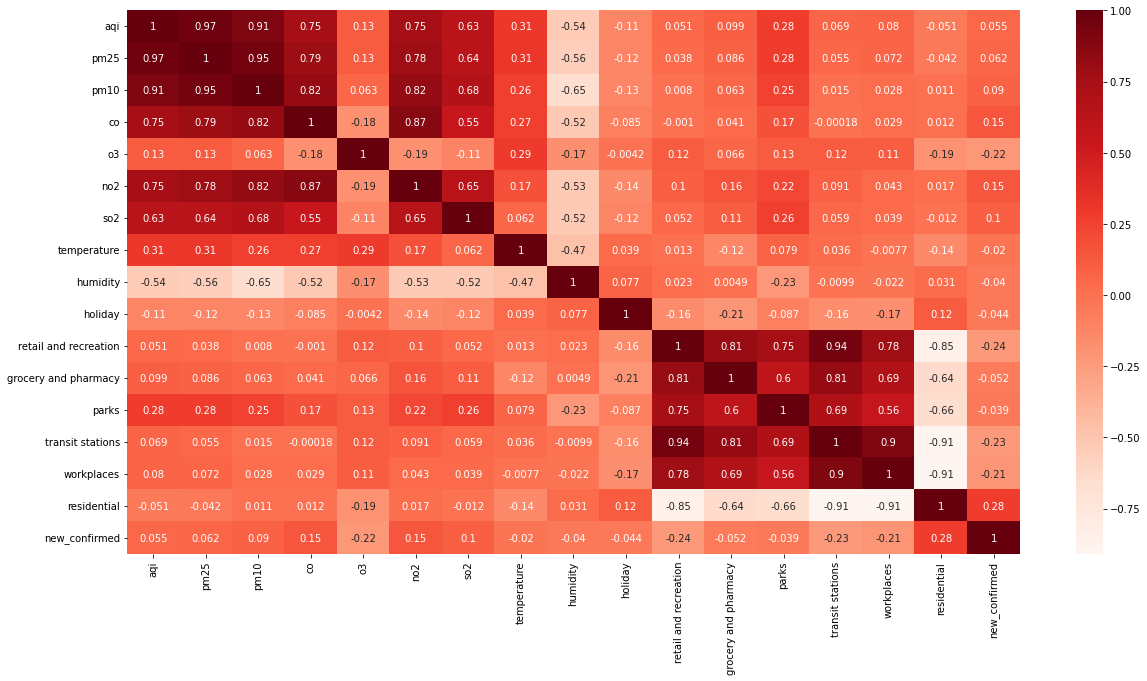

In [ ]:
plt.figure(figsize=(20,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
data['new_confirmed'] = data['new_confirmed'].astype(float)

data['new_confirmed_level'] = pd.qcut(data['new_confirmed'], 5, labels=False).astype(str).astype("int")
data['aqi_level'] = pd.qcut(data['aqi'], 6, labels=False).astype(str).astype("int")

# add additional features
data["day_of_week"] = data.date.dt.dayofweek.astype(str).astype("int")  # categories have be strings
data["week_of_year"] = data.date.dt.weekofyear.astype(str).astype("int")  # categories have be strings
data["month"] = data.date.dt.month.astype(str).astype("int")  # categories have be strings

data['holiday'] = data['holiday'].astype(str).astype("int")

data["time_idx"] = data.index

In [ ]:
data

date         aqi  pm25  pm10   co    o3   no2  so2  temperature  \
0   2020-02-25   67.333333  34.0  12.0  3.7  10.2   7.4  0.6         25.2   
1   2020-02-26   50.000000  25.0  10.0  4.6   5.3  11.5  1.6         22.0   
2   2020-02-27   42.000000  21.0  10.0  2.8  12.6   8.7  0.6         17.7   
3   2020-02-28   50.000000  25.0  16.0  2.8   8.6  11.0  1.1         18.3   
4   2020-02-29   59.166667  30.0  10.0  3.7   9.0   8.7  0.6         20.0   
..         ...         ...   ...   ...  ...   ...   ...  ...          ...   
673 2021-12-29  117.333333  59.0  21.0  2.8  24.0  10.6  1.1         20.1   
674 2021-12-30   83.666667  42.0  14.0  2.8  18.7  10.6  1.1         19.7   
675 2021-12-31   42.000000  21.0   9.0  3.7  11.8  10.6  0.6         19.5   
676 2022-01-01   91.833333  46.0  14.0  3.7  11.8   7.4  0.6         21.6   
677 2022-01-02   59.166667  30.0  12.0  2.8  11.8   6.9  0.6         22.0   

     humidity  ...  transit stations  workplaces  residential  new_confirmed  \
0        82.0  ...             -46.0       -66.0         14.0            1.0   
1        95.0  ...             -19.0       -15.0          7.0            0.0   
2        92.0  ...               5.0        10.0          1.0            0.0   
3        84.3  ...               7.0        14.0          0.0            1.0   
4        92.5  ...               6.0         6.0          2.0            0.0   
..        ...  ...               ...         ...          ...            ...   
673      86.5  ...             -23.0       -32.0         12.0            0.0   
674      88.0  ...             -26.0       -39.0         11.0            0.0   
675      92.0  ...             -50.0       -66.0         19.0            0.0   
676      82.1  ...             -59.0       -64.0          9.0            0.0   
677      88.0  ...             -22.0        -7.0          5.0            0.0   

     new_confirmed_level  aqi_level  day_of_week  week_of_year  month  \
0                      0          1            1             9      2   
1                      0          0            2             9      2   
2                      0          0            3             9      2   
3                      0          0            4             9      2   
4                      0          0            5             9      2   
..                   ...        ...          ...           ...    ...   
673                    0          3            2            52     12   
674                    0          2            3            52     12   
675                    0          0            4            52     12   
676                    0          2            5            52      1   
677                    0          0            6            52      1   

     time_idx  
0           0  
1           1  
2           2  
3           3  
4           4  
..        ...  
673       673  
674       674  
675       675  
676       676  
677       677  

[678 rows x 24 columns]

In [ ]:
data = data[['new_confirmed', 'new_confirmed_level', 'aqi', 'aqi_level',
                     'pm25', 'pm10', 'co', 'o3', 'no2', 'so2', 'temperature', 'humidity',
                     'retail and recreation', 'grocery and pharmacy', 'parks', 'transit stations', 'workplaces', 'residential',
                     'date', 'holiday', 'day_of_week', 'week_of_year', 'month', 'time_idx']]

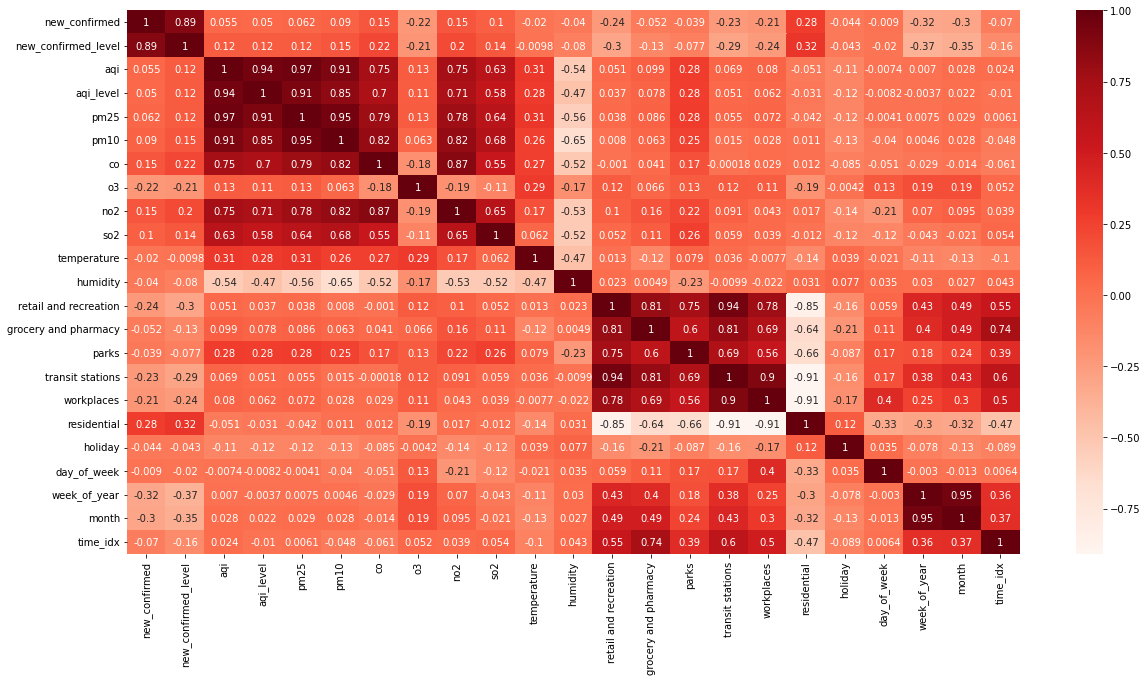

In [ ]:
plt.figure(figsize=(20,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

- `new_confirmed` positive to
    - `residential`
- `new_confirmed` negative to
    - `o3`, `retail and recreation`, `transit stations`, `workspaces`,  `week_of_year`
- `aqi` positive to
    - `pm25`, `pm10`, `co`, `no2`, `so2`, `temperature`
- `aqi` negative to
    - `humidity`
- `transit stations` positive to
    - `retail and recreation`, `grocery and pharmacy`, `parks`, `workplaces`
- `transit stations` negative to
    - `residential`

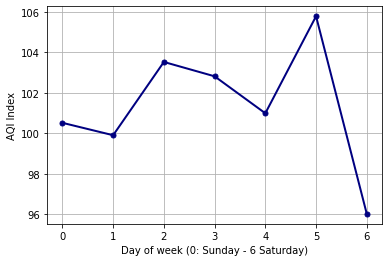

In [ ]:
gb_dayofweek_aqi = data.groupby(by=['day_of_week'])['aqi'].mean()

ax = gb_dayofweek_aqi.plot(lw=2, colormap='jet', marker='.', markersize=10)
ax.grid(which='both')
ax.set_xlabel("Day of week (0: Sunday - 6 Saturday)")
ax.set_ylabel("AQI Index");

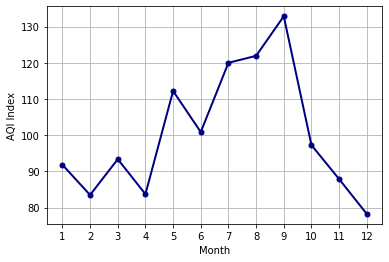

In [ ]:
gb_month_aqi = data.groupby(by=['month'])['aqi'].mean()

ax = gb_month_aqi.plot(lw=2, colormap='jet', marker='.', markersize=10)
ax.grid(which='both')
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xlabel("Month")
ax.set_ylabel("AQI Index");

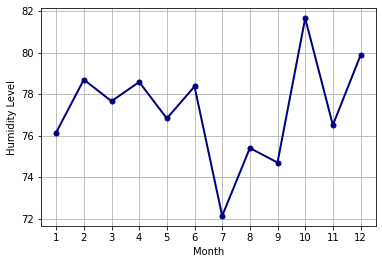

In [ ]:
gb_month_humidity = data.groupby(by=['month'])['humidity'].mean()

ax = gb_month_humidity.plot(lw=2, colormap='jet', marker='.', markersize=10)
ax.grid(which='both')
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xlabel("Month")
ax.set_ylabel("Humidity Level");

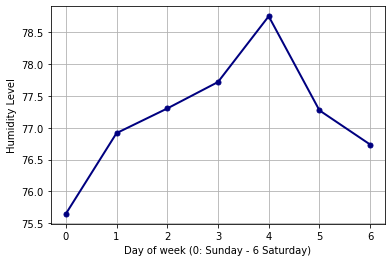

In [ ]:
gb_dayofweek_humidity = data.groupby(by=['day_of_week'])['humidity'].mean()

ax = gb_dayofweek_humidity.plot(lw=2, colormap='jet', marker='.', markersize=10)
ax.grid(which='both')
ax.set_xlabel("Day of week (0: Sunday - 6 Saturday)")
ax.set_ylabel("Humidity Level");

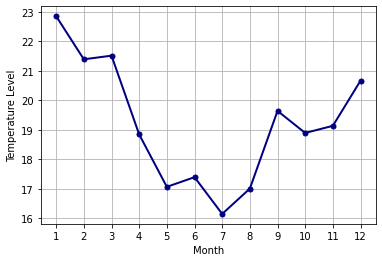

In [ ]:
gb_month_temperature = data.groupby(by=['month'])['temperature'].mean()

ax = gb_month_temperature.plot(lw=2, colormap='jet', marker='.', markersize=10)
ax.grid(which='both')
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xlabel("Month")
ax.set_ylabel("Temperature Level");

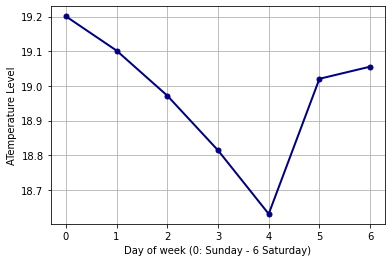

In [ ]:
gb_dayofweek_temperature = data.groupby(by=['day_of_week'])['temperature'].mean()

ax = gb_dayofweek_temperature.plot(lw=2, colormap='jet', marker='.', markersize=10)
ax.grid(which='both')
ax.set_xlabel("Day of week (0: Sunday - 6 Saturday)")
ax.set_ylabel("ATemperature Level");

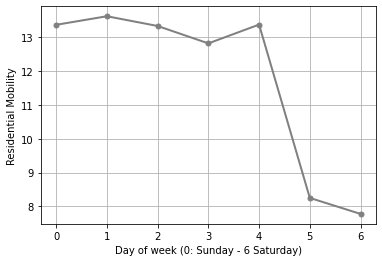

In [ ]:
gb_dayofweek_residential = data.groupby(by=['day_of_week'])['residential'].mean()

ax = gb_dayofweek_residential.plot(lw=2, color='gray', marker='.', markersize=10)
ax.grid(which='both')
ax.set_xlabel("Day of week (0: Sunday - 6 Saturday)")
ax.set_ylabel("Residential Mobility");

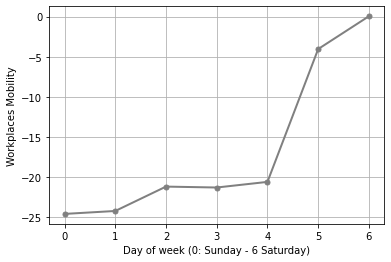

In [ ]:
gb_dayofweek_workplaces = data.groupby(by=['day_of_week'])['workplaces'].mean()

ax = gb_dayofweek_workplaces.plot(lw=2, color='gray', marker='.', markersize=10)
ax.grid(which='both')
ax.set_xlabel("Day of week (0: Sunday - 6 Saturday)")
ax.set_ylabel("Workplaces Mobility");

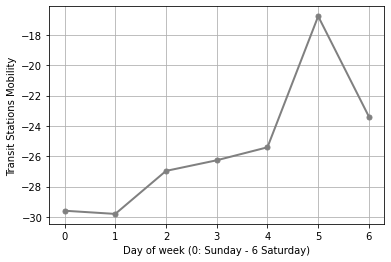

In [ ]:
gb_dayofweek_stations = data.groupby(by=['day_of_week'])['transit stations'].mean()

ax = gb_dayofweek_stations.plot(lw=2, color='gray', marker='.', markersize=10)
ax.grid(which='both')
ax.set_xlabel("Day of week (0: Sunday - 6 Saturday)")
ax.set_ylabel("Transit Stations Mobility");

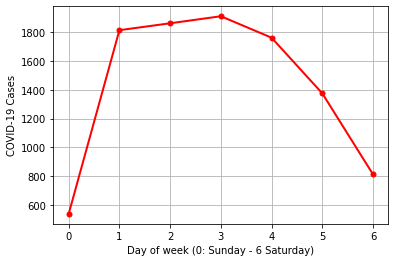

In [ ]:
gb_dayofweek_cases = data.groupby(by=['day_of_week'])['new_confirmed'].mean()

ax = gb_dayofweek_cases.plot(lw=2, color='red', marker='.', markersize=10)
ax.grid(which='both')
ax.set_xlabel("Day of week (0: Sunday - 6 Saturday)")
ax.set_ylabel("COVID-19 Cases");

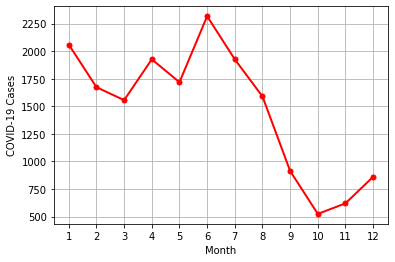

In [ ]:
gb_month_cases = data.groupby(by=['month'])['new_confirmed'].mean()

ax = gb_month_cases.plot(lw=2, color='red', marker='.', markersize=10)
ax.grid(which='both')
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xlabel("Month")
ax.set_ylabel("COVID-19 Cases");

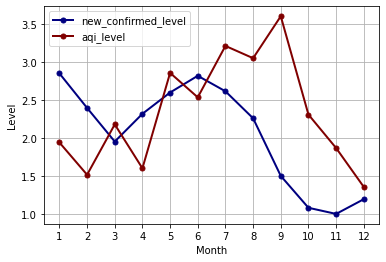

In [ ]:
gb_month_levels = data.groupby(by=['month'])['new_confirmed_level', 'aqi_level'].mean()

ax = gb_month_levels.plot(lw=2, colormap='jet', marker='.', markersize=10)
ax.grid(which='both')
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xlabel("Month")
ax.set_ylabel("Level");

In [ ]:
data.columns

Index(['new_confirmed', 'new_confirmed_level', 'aqi', 'aqi_level', 'pm25',
       'pm10', 'co', 'o3', 'no2', 'so2', 'temperature', 'humidity',
       'retail and recreation', 'grocery and pharmacy', 'parks',
       'transit stations', 'workplaces', 'residential', 'date', 'holiday',
       'day_of_week', 'week_of_year', 'month', 'time_idx'],
      dtype='object')

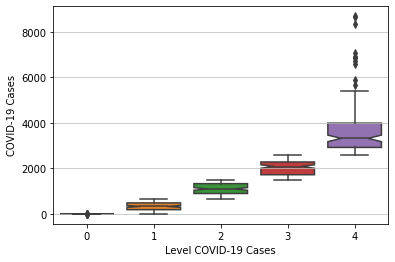

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=data, x="new_confirmed_level", y="new_confirmed",notch=True)
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75')
ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75')
ax.set_xlabel("Level COVID-19 Cases")
ax.set_ylabel("COVID-19 Cases");

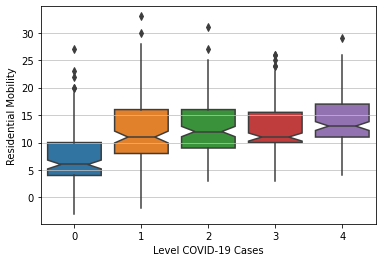

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=data, x="new_confirmed_level", y="residential",notch=True, showcaps=False,)
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75')
ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75')
ax.set_ylabel("Residential Mobility")
ax.set_xlabel("Level COVID-19 Cases");

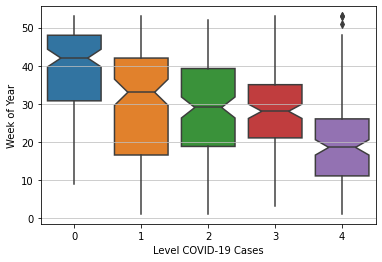

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=data, x="new_confirmed_level", y="week_of_year",notch=True, showcaps=False,)
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75')
ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75')
ax.set_ylabel("Week of Year")
ax.set_xlabel("Level COVID-19 Cases");

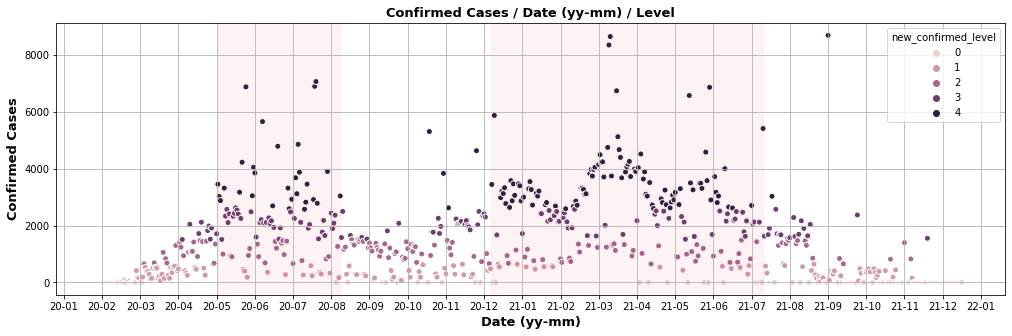

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (17, 5))
ax.axvspan(datetime.datetime.strptime('20-05-28', '%y-%m-%d'),
          datetime.datetime.strptime('20-09-01', '%y-%m-%d'),
          color="crimson",
          alpha=0.05)
ax.axvspan(datetime.datetime.strptime('20-12-28', '%y-%m-%d'),
          datetime.datetime.strptime('21-07-30', '%y-%m-%d'),
          color="crimson",
          alpha=0.05)

sns.scatterplot(x='date',y='new_confirmed',hue='new_confirmed_level',data=(data.groupby(['date', 'new_confirmed_level']).new_confirmed.sum().rename('new_confirmed')
                                                       .reset_index().sort_values('date', ascending = True, ignore_index=True)), linewidth = 1, alpha = 1)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.grid(True)

ax.set_xlabel('Date (yy-mm)', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('Confirmed Cases', color='black', fontweight='bold', fontsize=13)
ax.set_title('Confirmed Cases / Date (yy-mm) / Level', fontweight = 'bold', fontsize = 13);

In [ ]:
#data['new_confirmed_level'] = data['new_confirmed_level'].astype(str).astype("category")
#data['aqi_level'] = data['aqi_level'].astype(str).astype("category")

# add additional features
data["day_of_week"] = data["day_of_week"].astype(str).astype("category")  # categories have be strings
data["week_of_year"] = data["day_of_week"].astype(str).astype("category")  # categories have be strings
data["month"] = data["day_of_week"].astype(str).astype("category")  # categories have be strings

data['holiday'] = data['holiday'].astype(str).astype("category")

In [ ]:
from scipy.stats import normaltest
significancia = 0.05

<Axes: >

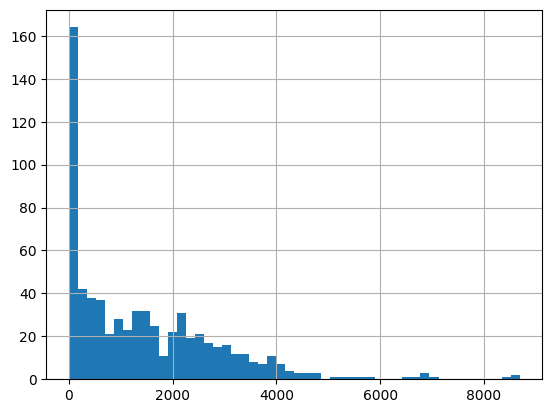

In [ ]:
data.new_confirmed.hist(bins = 50)

<Axes: >

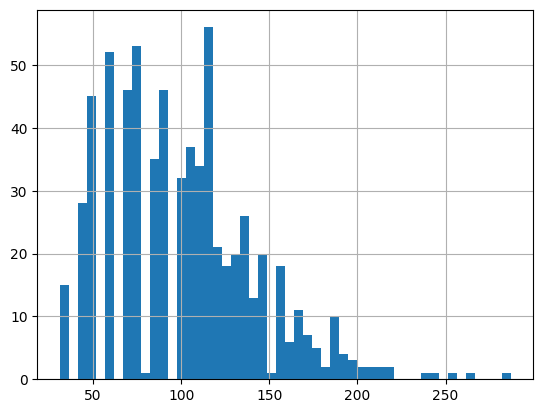

In [ ]:
data.aqi.hist(bins = 50)

In [ ]:
normaltest(data.aqi)

NormaltestResult(statistic=61.40397027904591, pvalue=4.637642533249198e-14)

In [ ]:
stat_test, p_valor = normaltest(data.aqi)
print(stat_test)
print(p_valor)

print(p_valor <= significancia)

61.40397027904591
4.637642533249198e-14
True


In [ ]:
stat_test, p_valor = normaltest(data.new_confirmed)
print(stat_test)
print(p_valor)

print(p_valor <= significancia)

182.3796755063775
2.4931973587564744e-40
True


O que ele está dizendo? Que é verdadeira a afirmação de rejeitar H0. Então, o que eu faço? Eu rejeito o H0. Que é o quê? É a hipótese de que a amostra é proveniente de uma distribuição normal.

In [ ]:
# Example of the Pearson's Correlation test
from scipy.stats import spearmanr
stat, p = spearmanr(data['new_confirmed'], data['aqi'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably independent')
else:
 print('Probably dependent')


stat=0.112, p=0.003
Probably dependent


t test statistic: 23.8998
p-value < 0.0001
Since the p-value is less than .05, we reject the null hypothesis of the paired samples t-test and conclude that there is sufficient evidence to say that the two methods lead to different mean exam scores.

In [ ]:
data = data[:-150]

# Dataset Building

In [ ]:
max_prediction_length = 8
max_encoder_length = max_prediction_length*8
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="new_confirmed",
    group_ids=["new_confirmed_level", "day_of_week"],
    min_encoder_length=max_prediction_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_prediction_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["holiday", "month", "day_of_week", "week_of_year"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=["new_confirmed_level", "aqi_level"],
    time_varying_unknown_reals=[
        "new_confirmed", 'aqi', 'pm25', 'pm10', 'co', 'o3', 'no2', 'so2', 'temperature',
        'humidity', 'retail and recreation', 'grocery and pharmacy',
        'parks', 'transit stations', 'workplaces', 'residential',
    ],
    target_normalizer=GroupNormalizer(
        groups=["new_confirmed_level", "day_of_week"], transformation="softplus"
    ),  # use softplus and normalize by group
    categorical_encoders={
        'week_of_year':NaNLabelEncoder(add_nan=True)
    },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

154.01136779785156

# TFT Model

## Training

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=50, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=200,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=32,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.2,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=32,  # set to <= hidden_size
    output_size=max_prediction_length,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 173.0k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 156   
3  | prescalers                         | ModuleDict                      | 1.3 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 13.4 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 96.0 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_9/checkpoints/epoch=199-step=3000.ckpt


In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs
#%tensorboard --logdir logs

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(38.4510)

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print('\n')
print(raw_predictions['prediction'].shape)



torch.Size([11, 8, 8])


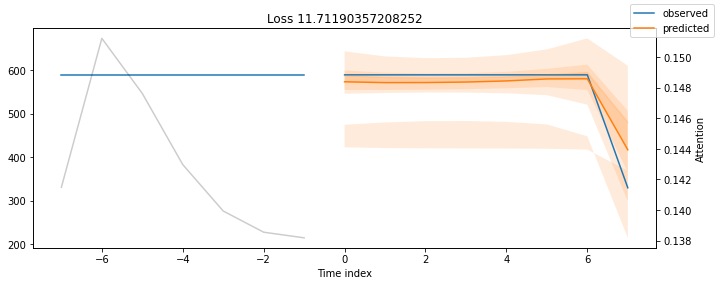

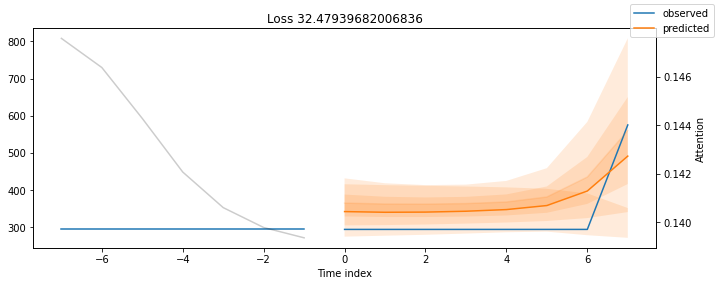

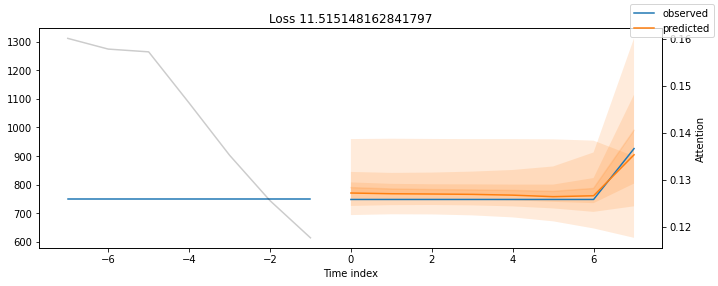

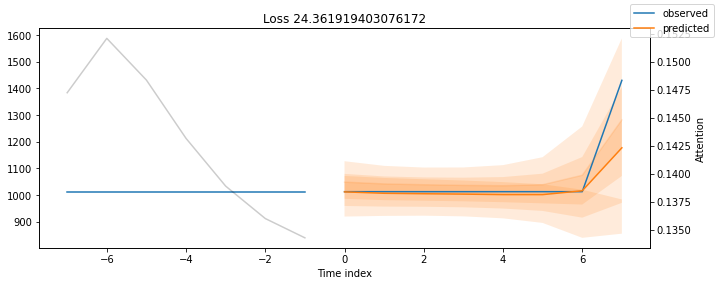

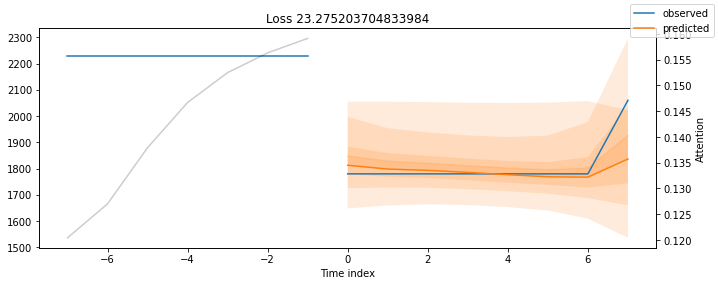

In [ ]:
for idx in range(5):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True,ax=ax)

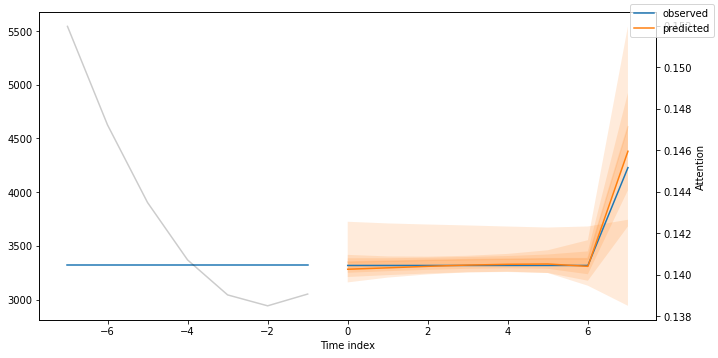

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.new_confirmed_level == "4")),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0, ax=ax);

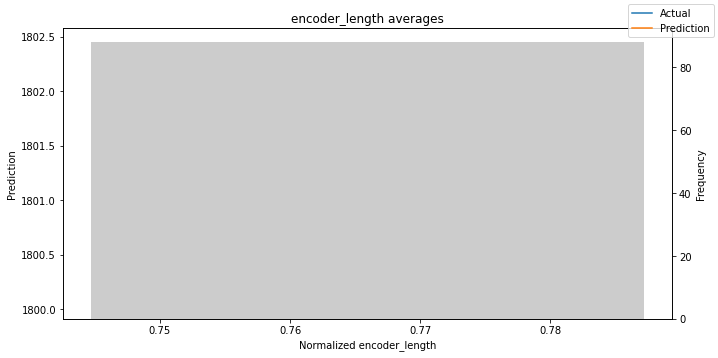

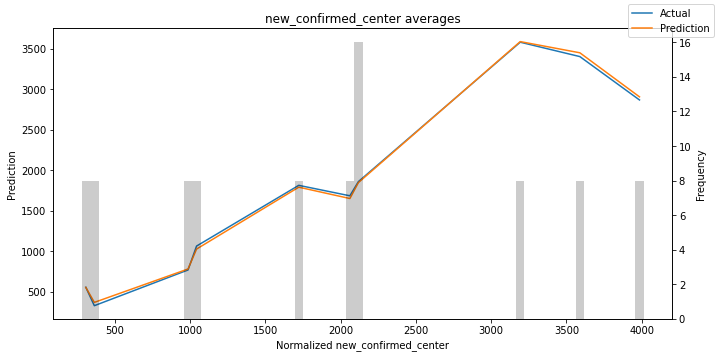

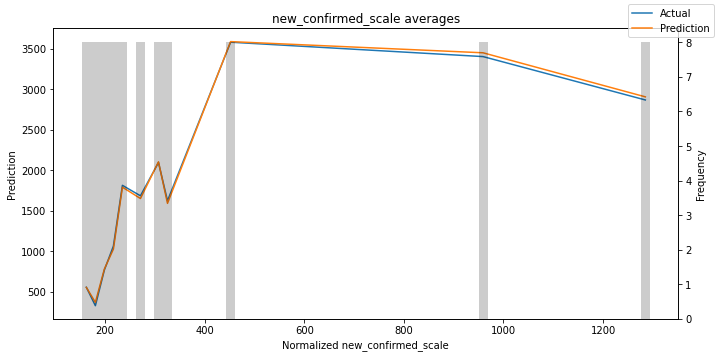

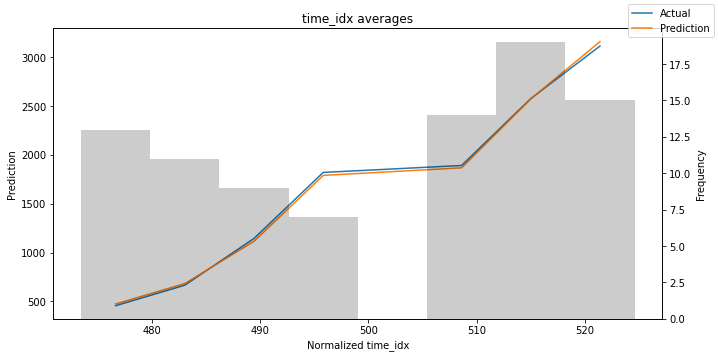

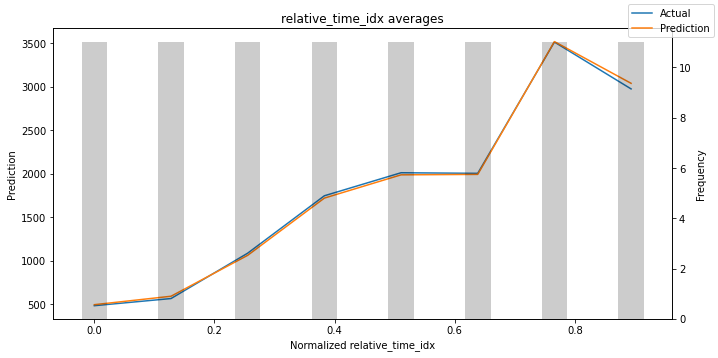

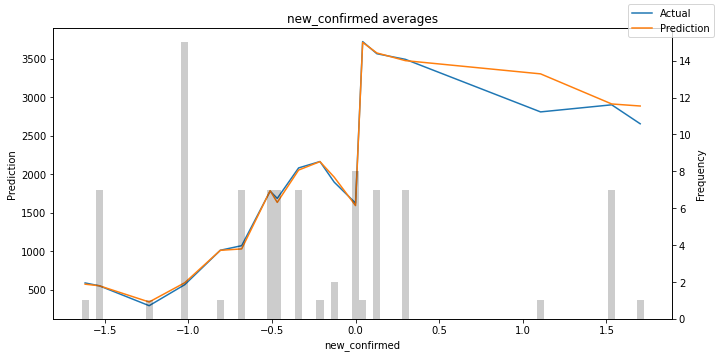

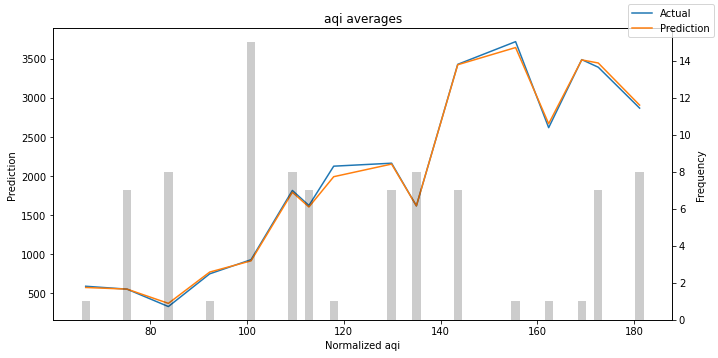

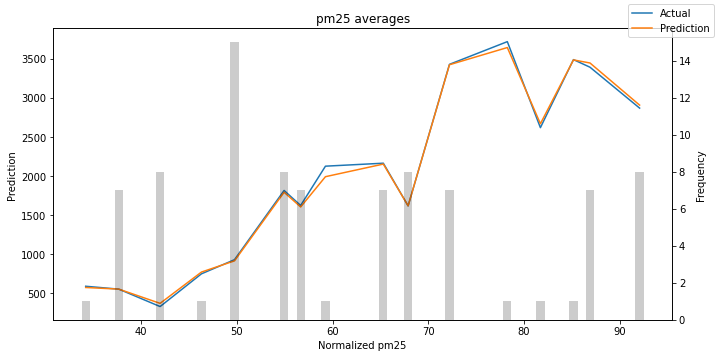

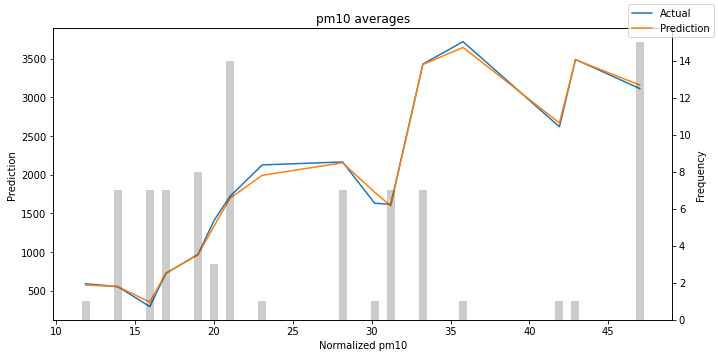

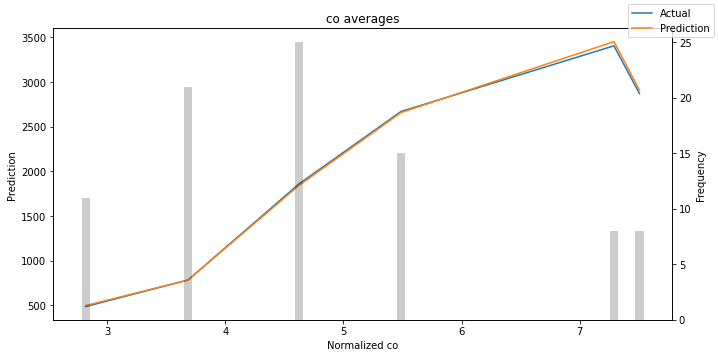

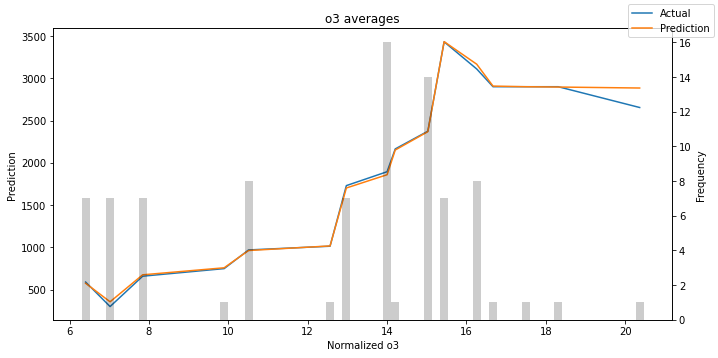

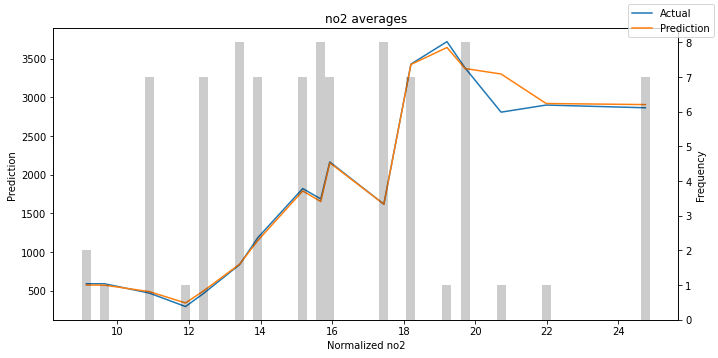

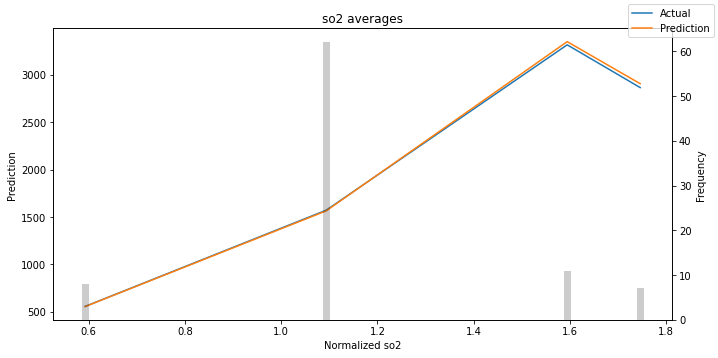

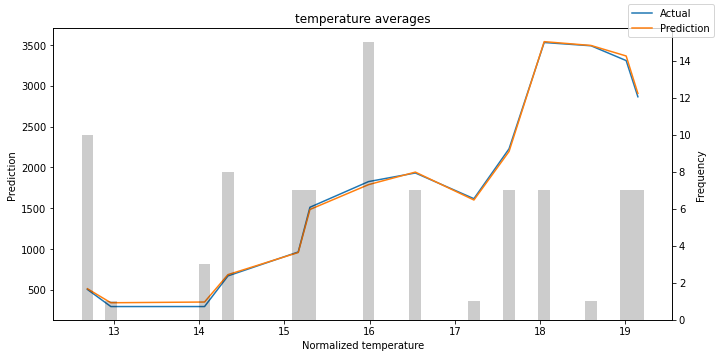

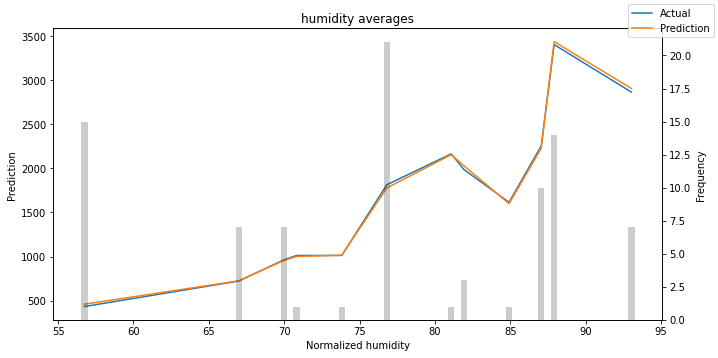

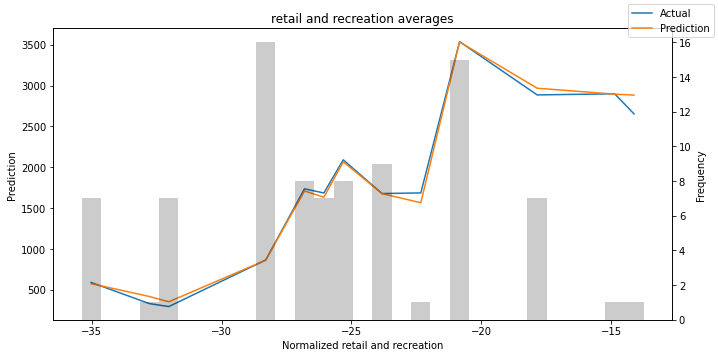

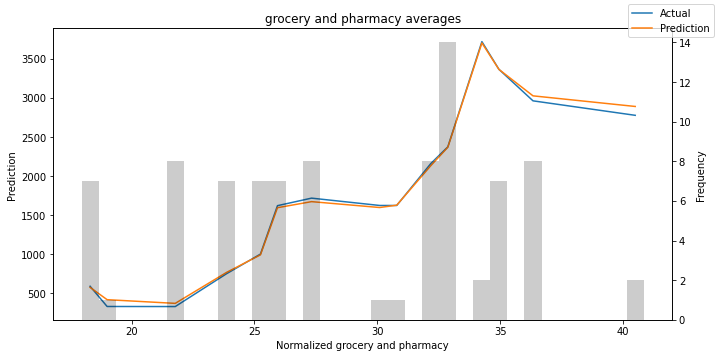

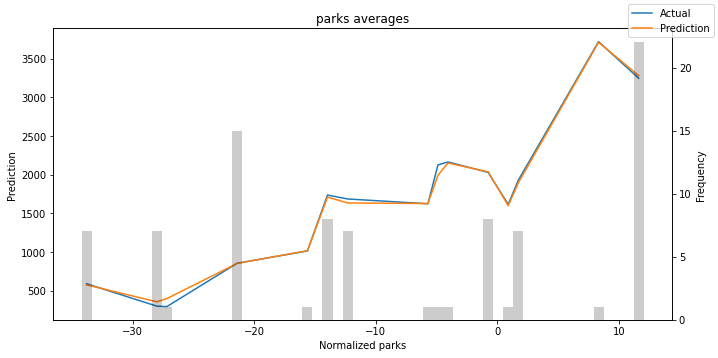

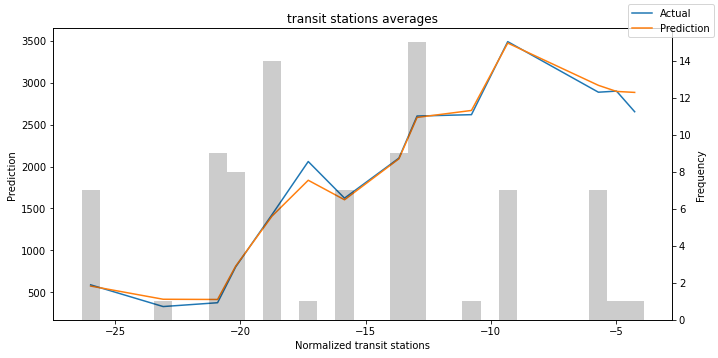

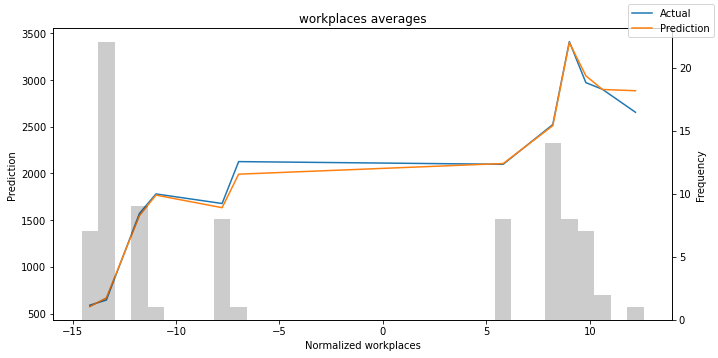

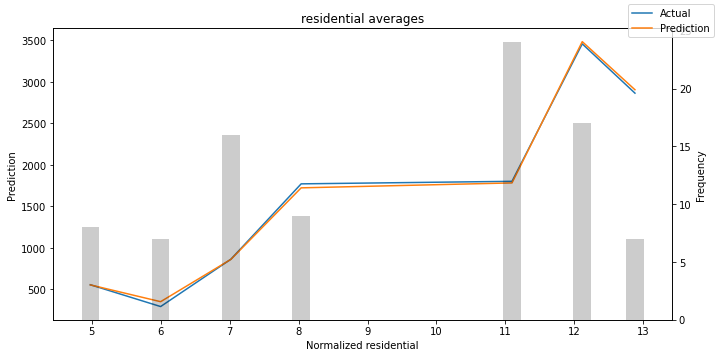

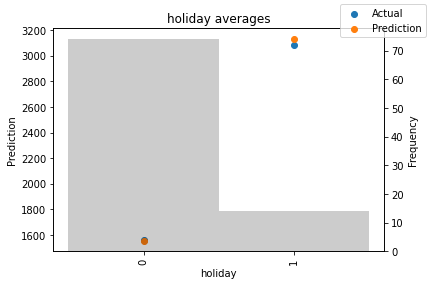

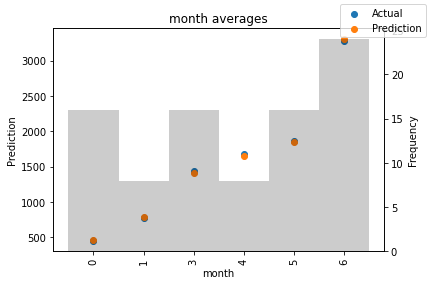

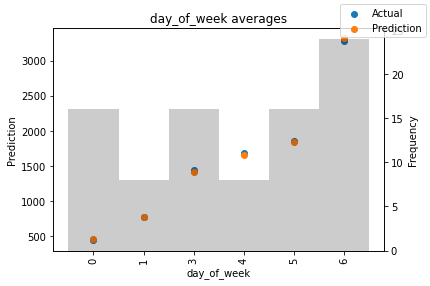

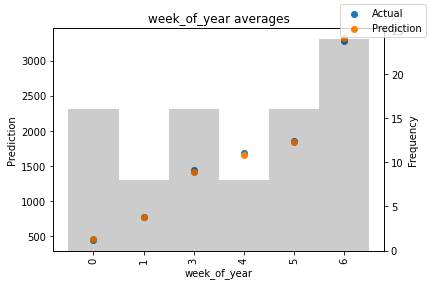

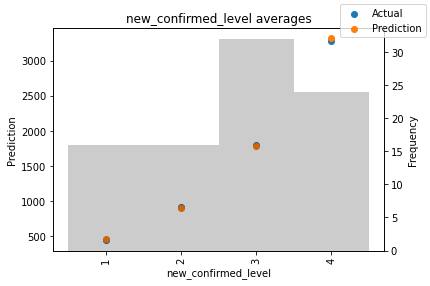

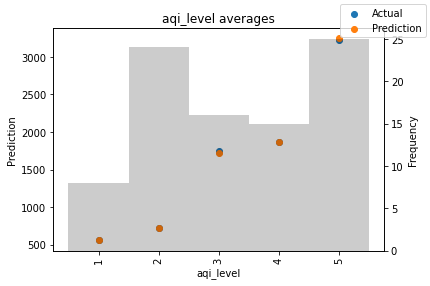

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [ ]:
#select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length*5 + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

In [ ]:
# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x198 with 1 Axes>,
 'encoder_variables': <Figure size 504x576 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>}

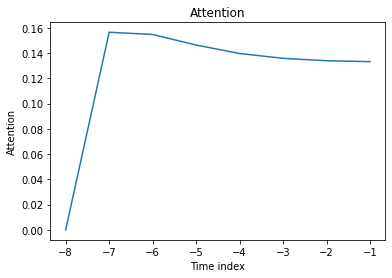

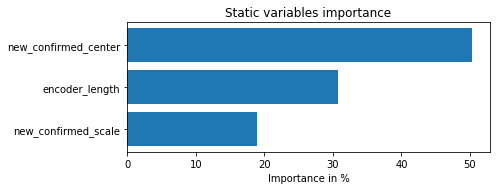

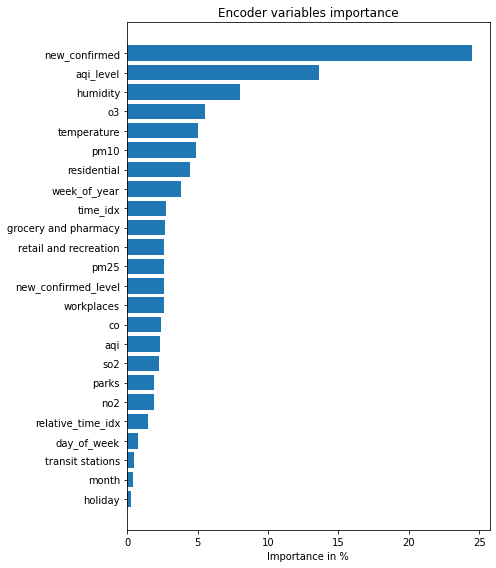

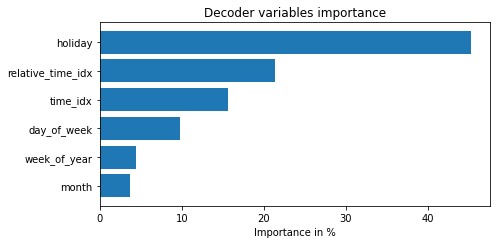

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)